In [ ]:
import os
from google.colab import drive

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Importações de ML
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, fbeta_score, make_scorer, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score

# Importações de reamostragem
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

## Montar Drive

In [ ]:
drive.mount('/content/drive')
output_path = '/content/drive/MyDrive/Ps_Ligia_Time_16/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carregar Datasets

In [ ]:
datasets = {
    "Base": pd.read_csv("/content/drive/MyDrive/PS-Ligia_Time16/risco_cardiovascular_base.csv"),
    "Features": pd.read_csv("/content/drive/MyDrive/PS-Ligia_Time16/risco_cardiovascular_features.csv")
}

## Definição de Hiperparâmetros para GridSearch

In [ ]:
#F2-Score (Atribui peso dobrado ao Recall em relação a Precisão) - Métrica de Desempenho

f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

In [ ]:
# Estruturação dos parâmetros para o GridSearch

resampler = [
    SMOTE(random_state=42),
    RandomOverSampler(random_state=42),
    RandomUnderSampler(random_state=42),
    'passthrough'
]

model_config = {
  'XGBoost_Clinical': {
    'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'params': {
        'resampler': [SMOTE(), 'passthrough'],
        'pca__n_components': [0.95, None],
        'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.01, 0.1]
    }
  }
}

## Loop de Treinamento

In [ ]:
model_save_path = os.path.join(output_path, 'models')
os.makedirs(model_save_path, exist_ok=True)

results_list = []

for ds_name, df in datasets.items():
    print(f"\n>>> Processando Dataset: {ds_name}")

    # Separar X e y
    df_clean = df.copy()
    if 'HighRisk' in df_clean.columns: # Categória de target binária (Não será utilizada nesse modelo)
        df_clean = df_clean.drop("HighRisk", axis=1)

    X = df_clean.drop('BP_Category', axis=1)
    le = LabelEncoder()
    y = le.fit_transform(df_clean['BP_Category'])

    # Tratamento de Dados

    bmi_order = ["Underweight", "Normal Weight", "Overweight", "Obese"]
    bmi_col = ["BMI Category"]

    cat_cols = [c for c in X.select_dtypes(include=['object']).columns if c != "BMI Category"]
    num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    preprocessor = ColumnTransformer(transformers=[
        ('ordinal', OrdinalEncoder(categories=[bmi_order]), bmi_col),
        ('numeric', StandardScaler(), num_cols),
        ('categories', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    for model_name, config in model_config.items():
      print(f"\n--- Iniciando GridSearch para {model_name} ---")

      pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('resampler', SMOTE()),
        ('pca', PCA()), # Define quanto da variância explicada original será mantida para no treinamento
        ('classifier', config['model'])
      ])

      cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

      grid = GridSearchCV(
          pipeline,
          config['params'],
          cv=cv,
          scoring={'f2': f2_scorer, 'accuracy': 'accuracy'},
          refit='f2', # O melhor modelo será escolhido pelo F2-Score
          n_jobs=-1
      )

      grid.fit(X_train, y_train)

      # Predições de Teste
      y_pred = grid.predict(X_test)
      y_proba = grid.predict_proba(X_test)

      # Cálculo de Métricas Adicionais para o relatório
      test_f2 = fbeta_score(y_test, y_pred, beta=2, average='weighted')
      test_precision = precision_score(y_test, y_pred, average='weighted')
      test_recall = recall_score(y_test, y_pred, average='weighted')
      test_f1 = f1_score(y_test, y_pred, average='weighted')

      # Salvamento
      model_filename = f"{model_name}_{ds_name}.pkl"
      joblib.dump(grid.best_estimator_, os.path.join(model_save_path, model_filename))

      # Registro de Resultados
      results_list.append({
          'Model': model_name,
          'Dataset': ds_name,
          'PCA_Used': grid.best_params_.get('pca__n_components') is not None,
          'SMOTE_Used': not isinstance(grid.best_params_.get('resampler'), str),
          'Best_Params': grid.best_params_,
          'Val_F2_Weighted': grid.best_score_,
          'Test_F2': test_f2,
          'Test_Recall (Sensib.)': test_recall,
          'Test_Precision': test_precision,
          'Test_F1': test_f1,
          'Test_Acc': accuracy_score(y_test, y_pred),
          'Test_AUC': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
        })


>>> Processando Dataset: Base

--- Iniciando GridSearch para XGBoost_Clinical ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:47:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



>>> Processando Dataset: Features

--- Iniciando GridSearch para XGBoost_Clinical ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:47:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Resultados

In [ ]:
# Melhor resultado para cada Dataset (Ordenado pelo F2-Score)
df_results = pd.DataFrame(results_list)

df_results = df_results.sort_values(by='Test_F2', ascending=False)
print("\n--- COMPARATIVO DE PERFORMANCE ---")

display(df_results[['Model', 'Dataset', 'PCA_Used', 'SMOTE_Used', 'Test_F2', 'Test_Recall (Sensib.)', 'Test_Precision', 'Test_AUC']])


--- COMPARATIVO DE PERFORMANCE ---


,Model,Dataset,PCA_Used,SMOTE_Used,Test_F2,Test_Recall (Sensib.),Test_Precision,Test_AUC
0,XGBoost_Clinical,Base,False,False,1.000000,1.000000,1.000000,1.0
1,XGBoost_Clinical,Features,False,False,0.986626,0.986667,0.987246,1.0


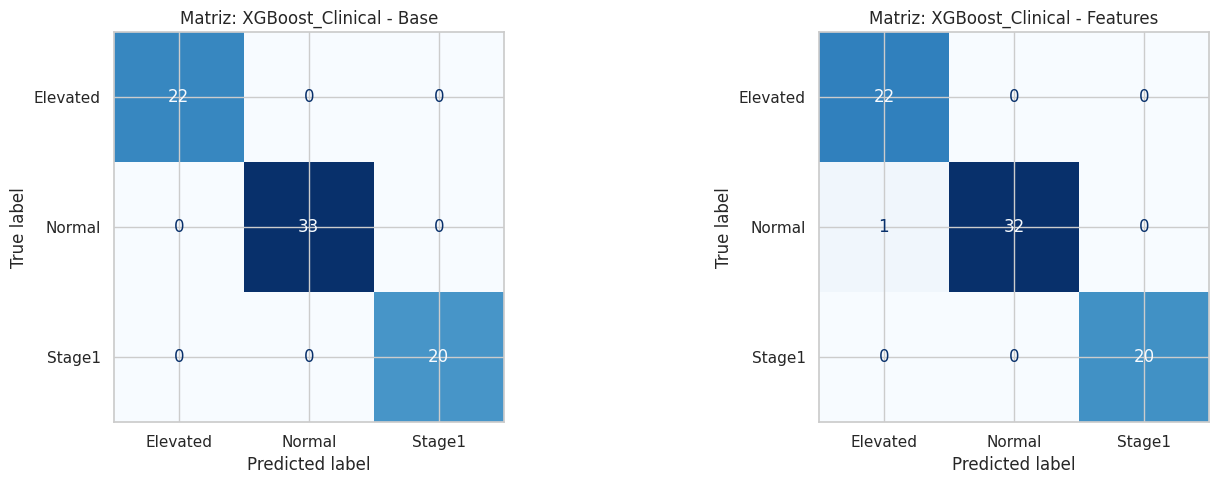

In [ ]:
# Matriz de Confusão (Visualização da precisão e recall do modelo)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, res in enumerate(results_list[:2]): # Pega os melhores de cada dataset
    model = joblib.load(os.path.join(model_save_path, f"{res['Model']}_{res['Dataset']}.pkl"))

    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f"Matriz: {res['Model']} - {res['Dataset']}")

plt.tight_layout()
plt.show()

### Visualização de *Feature Importance*

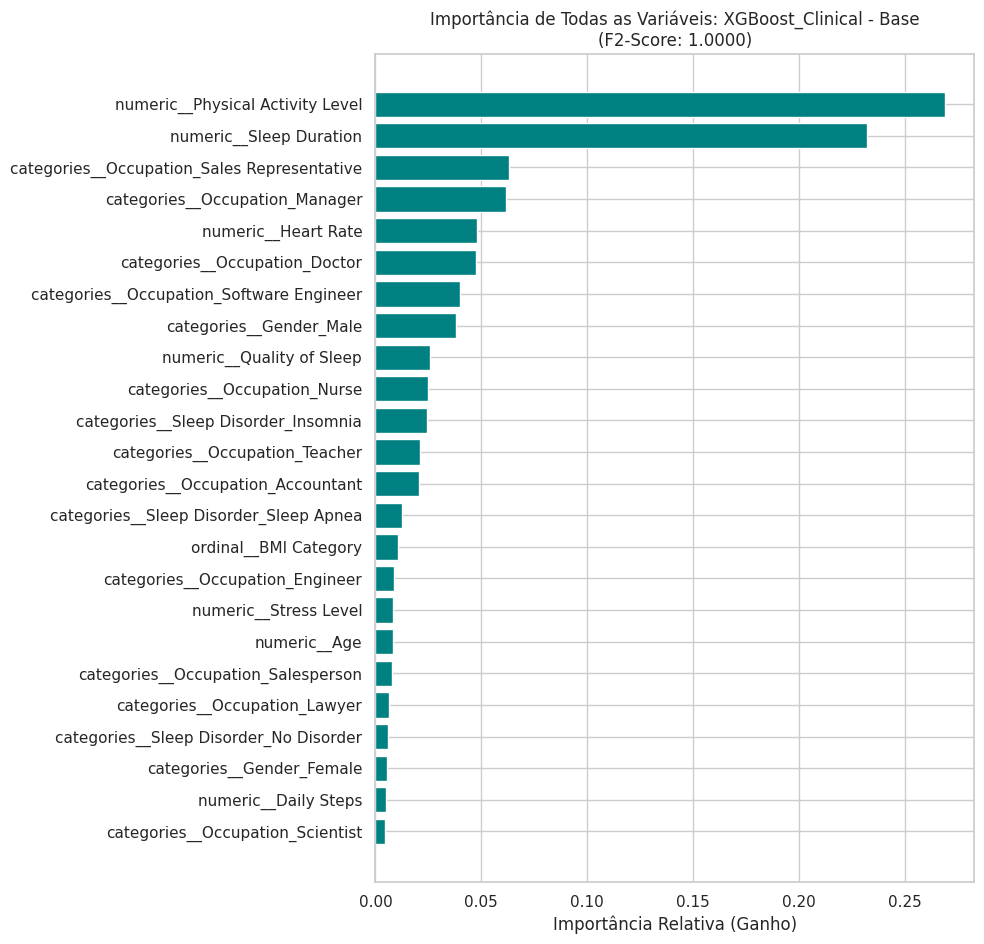

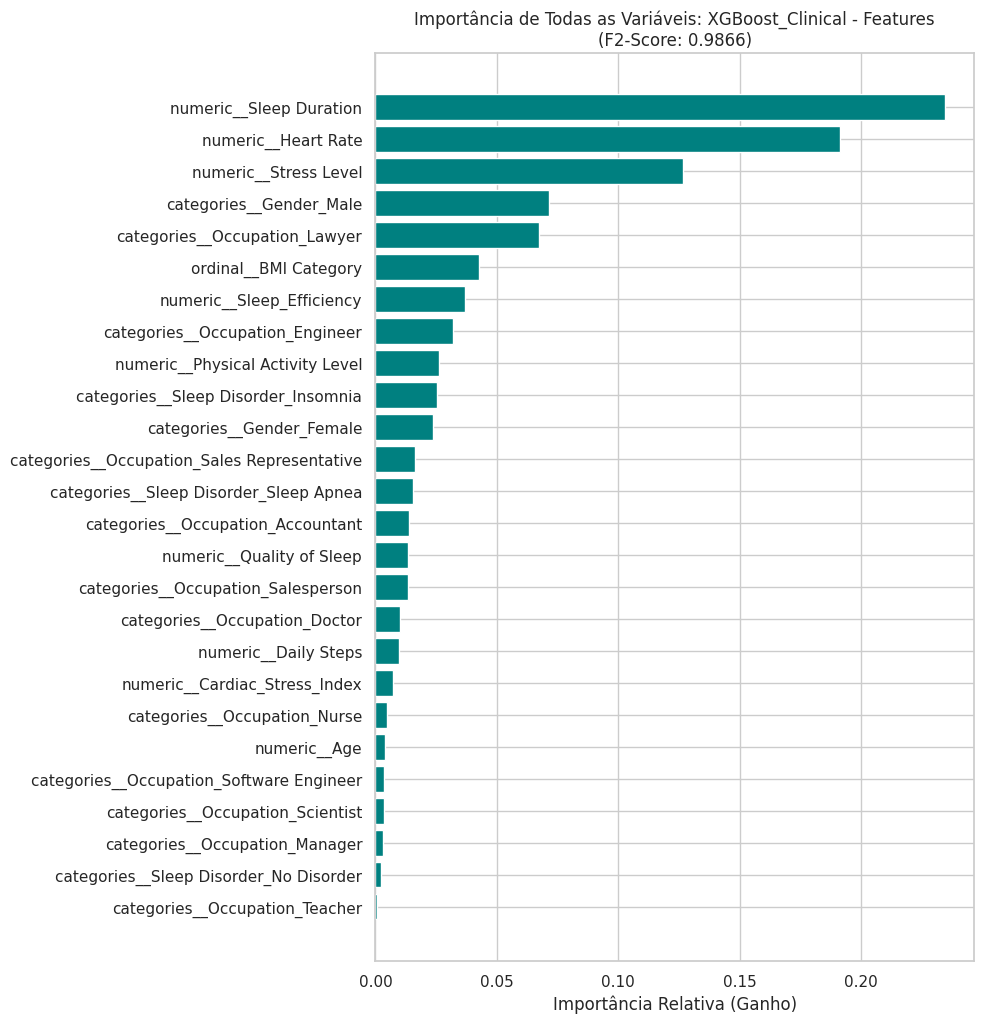

In [ ]:
# 1. Identificar o melhor modelo de cada dataset baseado no Test_F2
best_per_ds = pd.DataFrame(results_list).sort_values('Test_F2', ascending=False).drop_duplicates('Dataset')

for index, row in best_per_ds.iterrows():
    # Carregar o modelo salvo
    model_path = os.path.join(model_save_path, f"{row['Model']}_{row['Dataset']}.pkl")
    pipeline = joblib.load(model_path)

    # Extrair o classificador e os nomes das colunas
    xgb_model = pipeline.named_steps['classifier']
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

    # Extrair a importância nativa (Ganho/Gain)
    importances = xgb_model.feature_importances_
    df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    df_imp = df_imp.sort_values(by='Importance', ascending=True) # Todas as features

    # Ajustar o tamanho da figura dinamicamente baseada no número de colunas
    plt.figure(figsize=(10, 0.4 * len(df_imp)))

    plt.barh(df_imp['Feature'], df_imp['Importance'], color='teal')
    plt.title(f"Importância de Todas as Variáveis: {row['Model']} - {row['Dataset']}\n(F2-Score: {row['Test_F2']:.4f})")
    plt.xlabel("Importância Relativa (Ganho)")

    plt.tight_layout()
    plt.show()